In [90]:
library(Seurat)
library(Signac)
library(ggplot2)
library(BSgenome.Hsapiens.UCSC.hg19)
library(RColorBrewer)
library(pheatmap)
library(tidyverse)
set.seed(1234)
library(dplyr)
# library(scales)
# library(dichromat)

In [2]:
top_n = 20

In [45]:
processed_dir = "../../processed_data/chromVAR/motif_DEG/top20_filtered"
dir.create(processed_dir, recursive = T, showWarnings = F)

In [186]:
list_use=c('MA0497.1_MEF2C',
'MA1627.1_WT1',
'MA0114.4_HNF4A',
'MA0484.2_HNF4G',
'MA0046.2_HNF1A','MA1534.1_NR1I3',
'MA0065.2_PPARG::RXRA',
'MA0090.3_TEAD1',
'MA0788.1_POU3F3','MA1115.1_POU5F1','MA0792.1_POU5F1B',
'MA0643.1_ESRRG','MA0141.3_ESRRB',
          'MA1540.1_NR5A1',
'MA0662.1_MIXL1',
'MA0707.1_MNX1',
'MA0482.2_GATA4',
'MA0598.3_EHF',
'MA0640.2_ELF3',
'MA0480.1_FOXO1','MA0481.3_FOXP1','MA0042.2_FOXI1',
'MA0647.1_GRHL1',
'MA1105.2_GRHL2',
'MA1152.1_SOX15',
'MA0868.2_SOX8',
'MA0624.1_NFATC1',
'MA0836.2_CEBPD','MA0002.2_RUNX1',
 'MA0645.1_ETV6','MA0475.2_FLI1','MA0098.3_ETS1','MA0765.2_ETV5'
         )

### load wnn object

In [4]:
Sys.time()
load("../../processed_data/wnn/20221221_324701_cells_wnn.RData")
Sys.time()

[1] "2023-07-06 17:04:32 CDT"

[1] "2023-07-06 17:08:40 CDT"

In [5]:
ls()

[1] "level.novaseq"                    "level.novaseq.renal_region_new"  
[3] "level.novaseq.rna"                "novaseq.wnn"                     
[5] "palette.novaseq"                  "palette.novaseq.renal_region_new"
[7] "palette.novaseq.rna"              "processed_dir"                   
[9] "top_n"

In [6]:
novaseq = novaseq.wnn
novaseq
table(novaseq$celltype_atac5)
class(novaseq$celltype_atac5)
table(novaseq$celltype5_rna)
class(novaseq$celltype5_rna)

An object of class Seurat 
237522 features across 324701 samples within 2 assays 
Active assay: peaks (189184 features, 189184 variable features)
 1 other assay present: RNA
 6 dimensional reductions calculated: pca, harmony_RNA, lsi, harmony_peaks, umap.peaks, WNN.UMAP


 POD/PEC       PT PT_VCAM1      tL1      tL2   tL-TAL     TAL1   TAL2/3 
    1766    93543    12319    25095     8878    20544    35720    18326 
     DCT      CNT      PC1      PC2       IC      Uro     ENDO      SMC 
   17704     9950    15729     3497    14133     3089    14049     4513 
    Fib1     Fib2     Fib3       Ma       BT 
    4668    10435      441     4136     6166 

[1] "factor"


      JGA       POD       PEC        PT PT_dediff  PT_VCAM1       tL1       tL2 
     2465      3179      1239     64880     29494      8445     25438      9029 
   tL-TAL      TAL1      TAL2      TAL3       DCT       CNT       PC1       PC2 
    15485     29910     19724      8900     14150     13197     16140      4049 
      ICA       ICB      Uro1      Uro2      ENDO      SMC1      SMC2      SMC3 
    10579      4120      3210       682     12847      4272       156        86 
     Fib1      Fib2      Fib3        Ma        BT 
     3786      7191      3095      3673      5280 

[1] "factor"

In [7]:
Idents(novaseq) = 'celltype5_rna'
head(Idents(novaseq))

R1.034,R2.082,R3.082,P1.76,B3 R1.047,R2.073,R3.003,P1.65,B2 
                          tL1                           PEC 
R1.025,R2.080,R3.017,P1.66,B2 R1.056,R2.038,R3.008,P1.48,B2 
                    PT_dediff                          TAL1 
R1.089,R2.082,R3.024,P1.14,B1 R1.031,R2.072,R3.075,P1.78,B3 
                          CNT                          TAL2 
29 Levels: JGA POD PEC PT PT_dediff PT_VCAM1 tL1 tL2 tL-TAL TAL1 TAL2 ... BT

### load chromvar assay and da_motifs (DE chromVAR motif score)

In [8]:
load("../../processed_data/chromVAR/multiome_chromvar_assay_and_DEmotif_minpct0.1_padj0.01.RData")

In [9]:
ls()

[1] "chromvar_assay"                   "da_motifs"                       
 [3] "da_motifs_raw"                    "level.novaseq"                   
 [5] "level.novaseq.renal_region_new"   "level.novaseq.rna"               
 [7] "novaseq"                          "novaseq.wnn"                     
 [9] "palette.novaseq"                  "palette.novaseq.renal_region_new"
[11] "palette.novaseq.rna"              "processed_dir"                   
[13] "top_n"

### add chromvar assay to Seurat assay

In [10]:
novaseq[['chromvar']] = chromvar_assay

In [11]:
novaseq

An object of class Seurat 
238268 features across 324701 samples within 3 assays 
Active assay: peaks (189184 features, 189184 variable features)
 2 other assays present: RNA, chromvar
 6 dimensional reductions calculated: pca, harmony_RNA, lsi, harmony_peaks, umap.peaks, WNN.UMAP

### load DEG

In [12]:
# DEG = read.csv("../../processed_data/chromVAR/multiome_RNA_DEG_minpct0.1_padj0.01.csv")
load("../../processed_data/chromVAR/multiome_RNA_DEG_minpct0.1_padj0.01.RData")

In [13]:
ls()

[1] "chromvar_assay"                   "da_motifs"                       
 [3] "da_motifs_raw"                    "DEG"                             
 [5] "DEG_raw"                          "level.novaseq"                   
 [7] "level.novaseq.renal_region_new"   "level.novaseq.rna"               
 [9] "novaseq"                          "novaseq.wnn"                     
[11] "palette.novaseq"                  "palette.novaseq.renal_region_new"
[13] "palette.novaseq.rna"              "processed_dir"                   
[15] "top_n"

### assign DEG and Motif

In [56]:
# assign raw DEG and raw Motif
DEG = DEG_raw
Motif <- da_motifs

# #Consider only up DEGs with p_val_adj < 0.01
# DEG <- DEG[DEG$p_val_adj < 0.01,]
# #Consider only up regulated genes
# DEG <- DEG[which(DEG$avg_log2FC>=0.1),]
# DEG_raw[DEG_raw$gene =='NFAT5',]

# #Read in list with differentially active motifs

# Motif <- Motif[which(Motif$motif.avg_diff.>=0.05),]
Motif$gene <- toupper(Motif$gene)

dim(DEG)
head(DEG)

dim(Motif)
head(Motif)

[1] 34292     7

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
SLIT3,0,3.090906,0.631,0.199,0,JGA,SLIT3
EBF1,0,3.010133,0.577,0.139,0,JGA,EBF1
CARMN,0,2.849478,0.417,0.050,0,JGA,CARMN
CACNA1C,0,2.836649,0.620,0.203,0,JGA,CACNA1C
DLC1,0,2.728742,0.538,0.195,0,JGA,DLC1
PDGFRB,0,2.625217,0.327,0.034,0,JGA,PDGFRB


[1] 11363     8

,motif.p_val,motif.avg_diff.,motif.pct.1,motif.pct.2,motif.p_val_adj,cluster,gene,motif
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
MA0497.1,0.000000e+00,1.1415628,0.807,0.496,0.000000e+00,JGA,MEF2C,MA0497.1
MA0052.4,0.000000e+00,1.0785126,0.794,0.495,0.000000e+00,JGA,MEF2A,MA0052.4
MA0660.1,0.000000e+00,1.0401525,0.791,0.494,0.000000e+00,JGA,MEF2B,MA0660.1
MA0773.1,0.000000e+00,1.0044398,0.787,0.494,0.000000e+00,JGA,MEF2D,MA0773.1
MA1653.1,1.859992e-313,0.5411834,0.783,0.492,1.387554e-310,JGA,ZNF148,MA1653.1
MA0050.2,8.854866e-306,0.8571013,0.774,0.481,6.605730e-303,JGA,IRF1,MA0050.2


### generate heatmap for top chromVAR and top DEGs only, without overlap

In [57]:
topN_motif <- Motif  %>% 
group_by(cluster) %>% 
top_n(n = top_n, wt = motif.avg_diff.) %>%
arrange(desc(motif.avg_diff.), .by_group = TRUE)

head(topN_motif)


motif.p_val,motif.avg_diff.,motif.pct.1,motif.pct.2,motif.p_val_adj,cluster,gene,motif
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
1.496046e-102,1.247131,0.705,0.438,1.116050e-99,JGA,FOSL1::JUN,MA1128.1
1.457144e-110,1.237793,0.700,0.436,1.087030e-107,JGA,JUNB,MA0490.2
8.144423e-103,1.223784,0.701,0.437,6.075739e-100,JGA,FOSL1::JUNB,MA1137.1
5.381950e-99,1.223764,0.694,0.438,4.014935e-96,JGA,FOSL2::JUN,MA1130.1
9.598327e-100,1.223220,0.703,0.436,7.160352e-97,JGA,FOSL1,MA0477.2
2.655555e-98,1.221100,0.696,0.437,1.981044e-95,JGA,FOS::JUND,MA1141.1


In [58]:
novaseq_test = novaseq

In [59]:
novaseq_test@assays$chromvar@counts <- novaseq_test@assays$chromvar@data

In [187]:
get_aver = function(novaseq, assays, features, slot, Motifs){
    # calculate aver_chromvar
    aver <- AverageExpression(novaseq,assays = assays, features = features,slot = slot) %>% as.data.frame()
    colnames(aver) = gsub(paste0(assays,"."), "", colnames(aver))
    return(aver)
}

In [75]:
topN_unique_motif = unique(topN_motif$motif)
topN_unique_motif = c(topN_unique_motif, c('MA0606.1', 'MA0002.2'))

In [76]:
aver_chromvar = get_aver(novaseq = novaseq_test,
        assays = "chromvar",
        features = topN_unique_motif,
        slot="counts")

In [77]:
rownames(aver_chromvar) = paste0(row.names(aver_chromvar) ,sep="_", 
       unname(sapply(rownames(aver_chromvar), FUN = function(x){
    unique(Motif[(Motif$motif == x), "gene"])
})))

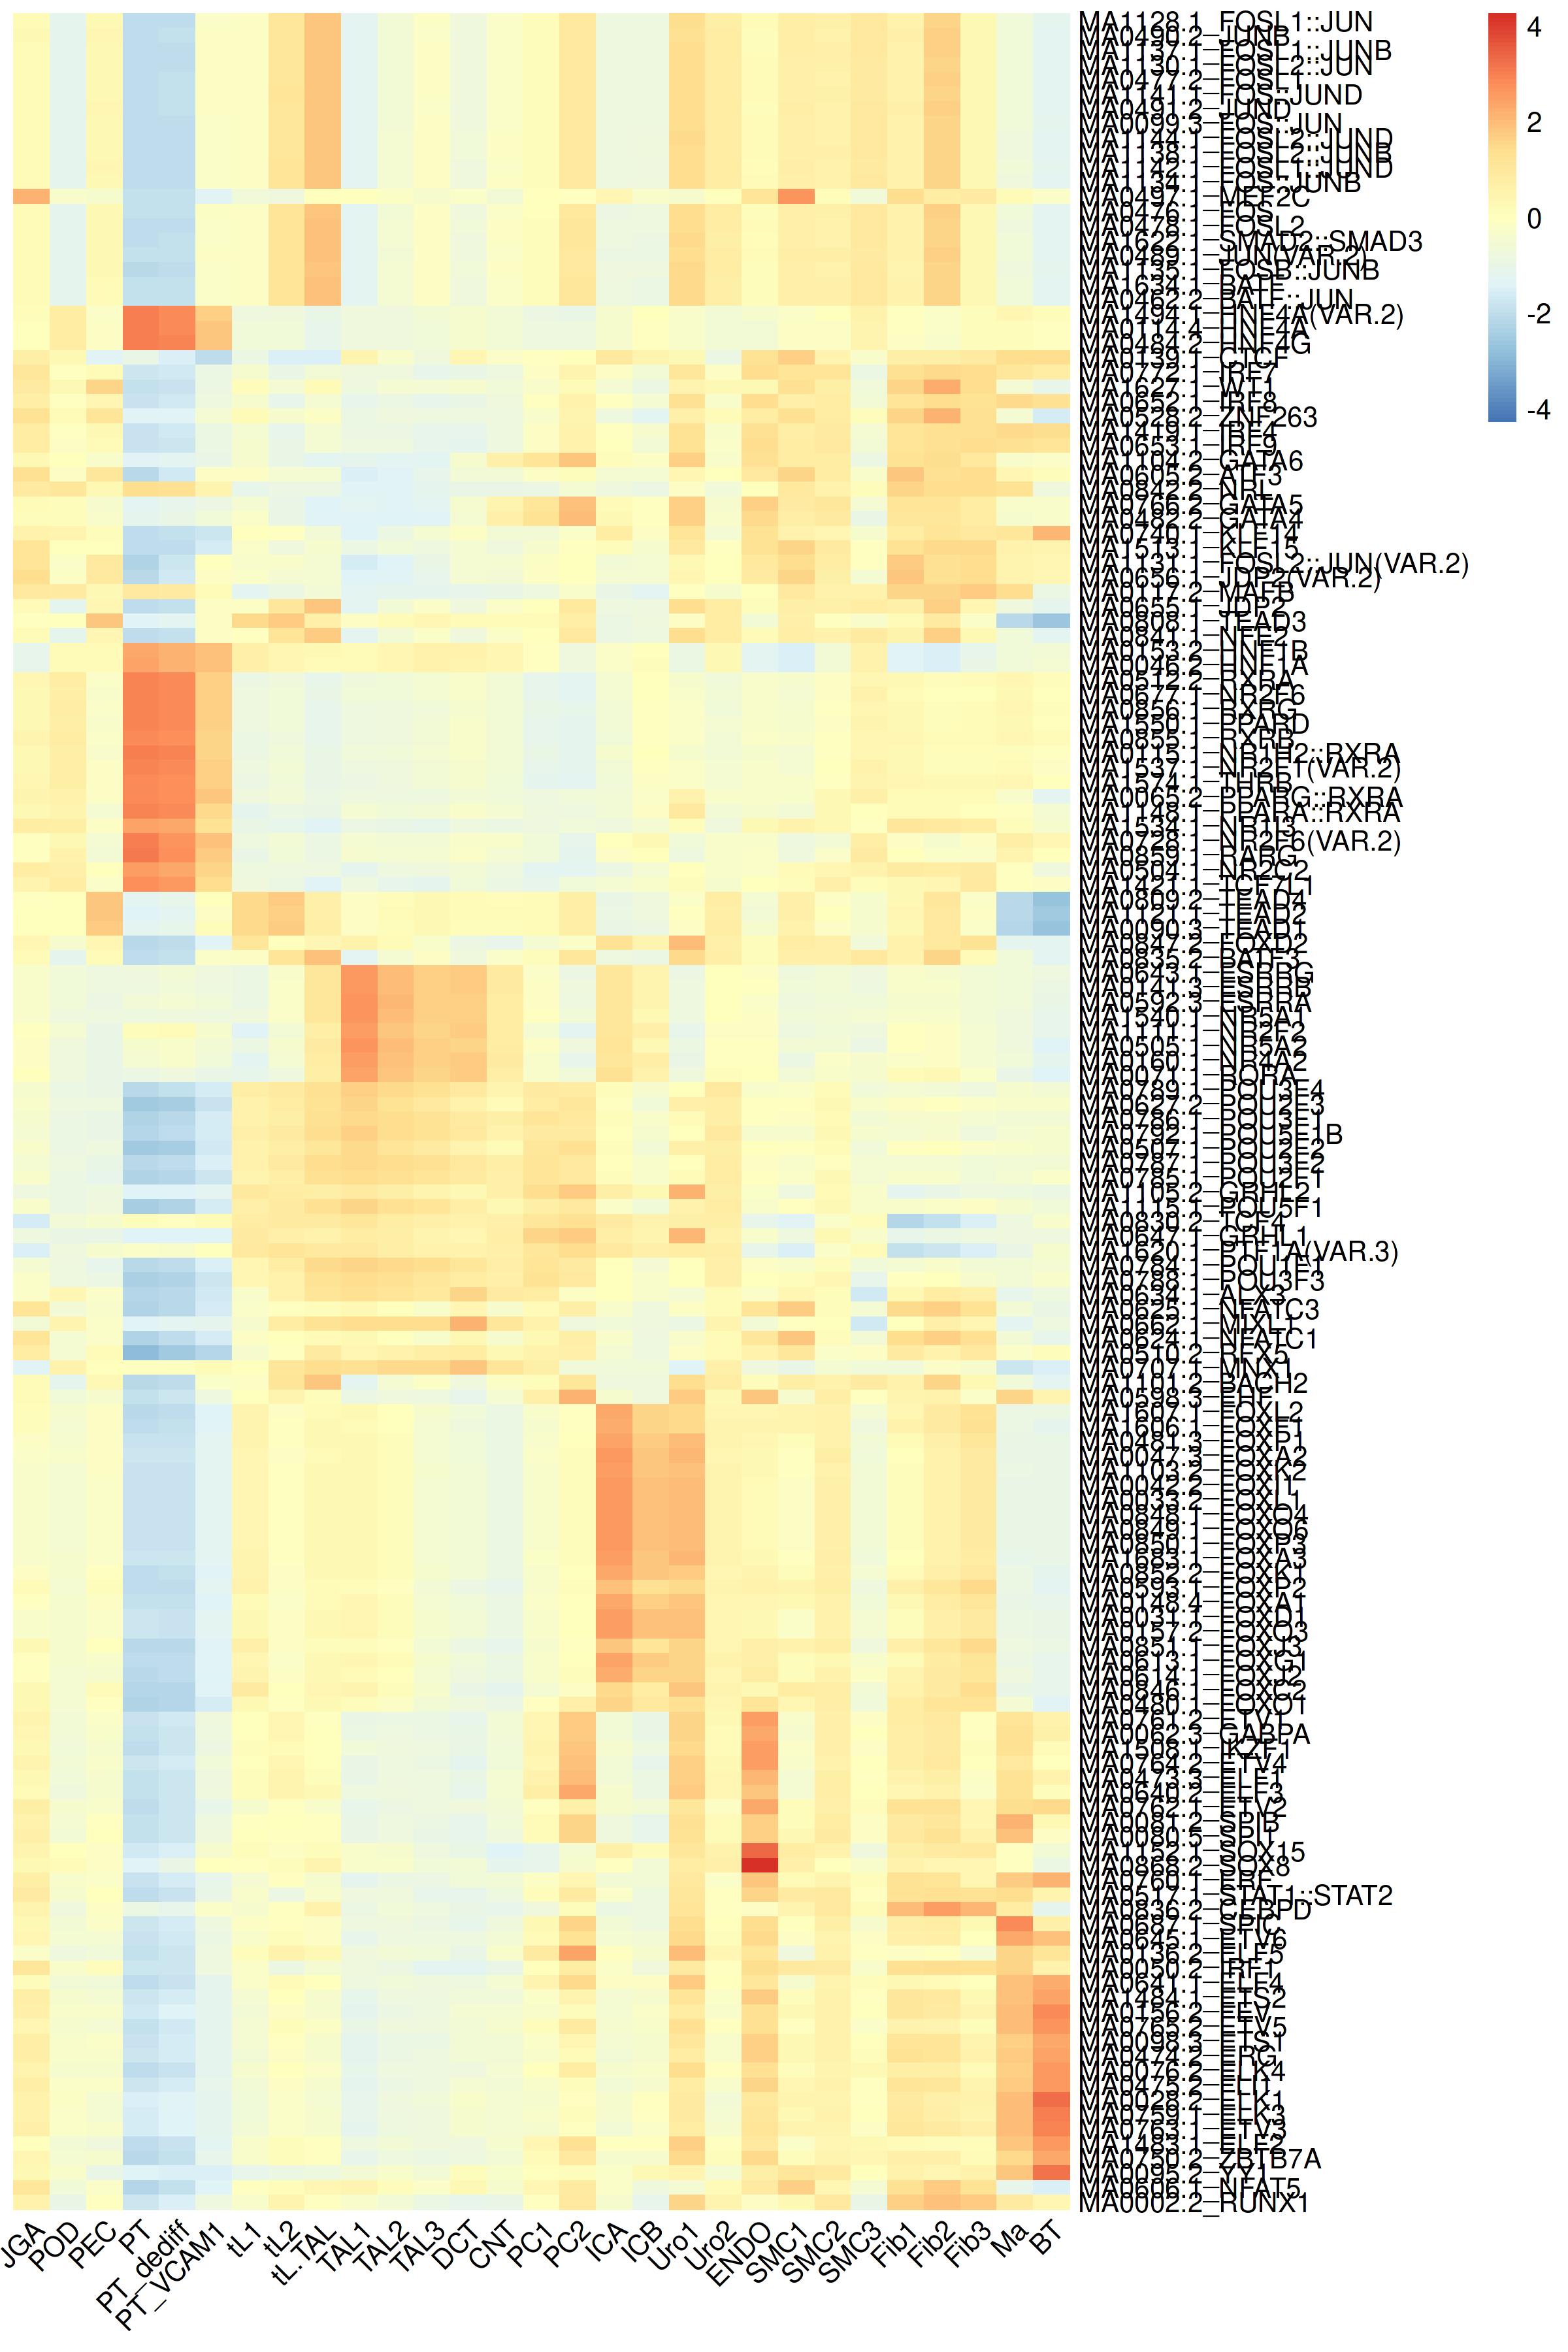

In [78]:
library(repr)
options(repr.plot.height = 12, repr.plot.width = 8, repr.plot.res = 300)

pheatmap::pheatmap(aver_chromvar,scale = "row",
                   cluster_cols=F,cluster_rows = F,
#                    color = col.pal,
                   show_rownames=T, angle_col=45)

### use user defined gene list_use

In [188]:
aver_chromvar = get_aver(novaseq = novaseq_test,
        assays = "chromvar",
        features = do.call(rbind, strsplit(list_use, "_"))[,1],
        slot="counts")

In [189]:
rownames(aver_chromvar) = paste0(row.names(aver_chromvar) ,sep="_", 
       unname(sapply(rownames(aver_chromvar), FUN = function(x){
    unique(Motif[(Motif$motif == x), "gene"])
})))

### remove Uro2, SMC1, SMC2 clusters, and change tL.TAL to tL-TAL

In [190]:
aver_chromvar = aver_chromvar[, !(colnames(aver_chromvar) %in% c("Uro2", "SMC2", "SMC3"))]

In [191]:
colnames(aver_chromvar) = gsub("\\.", "-", colnames(aver_chromvar))

In [192]:
save(list = c("aver_chromvar"), file = file.path(processed_dir, "aver_chromvar.RData"), compress = T)

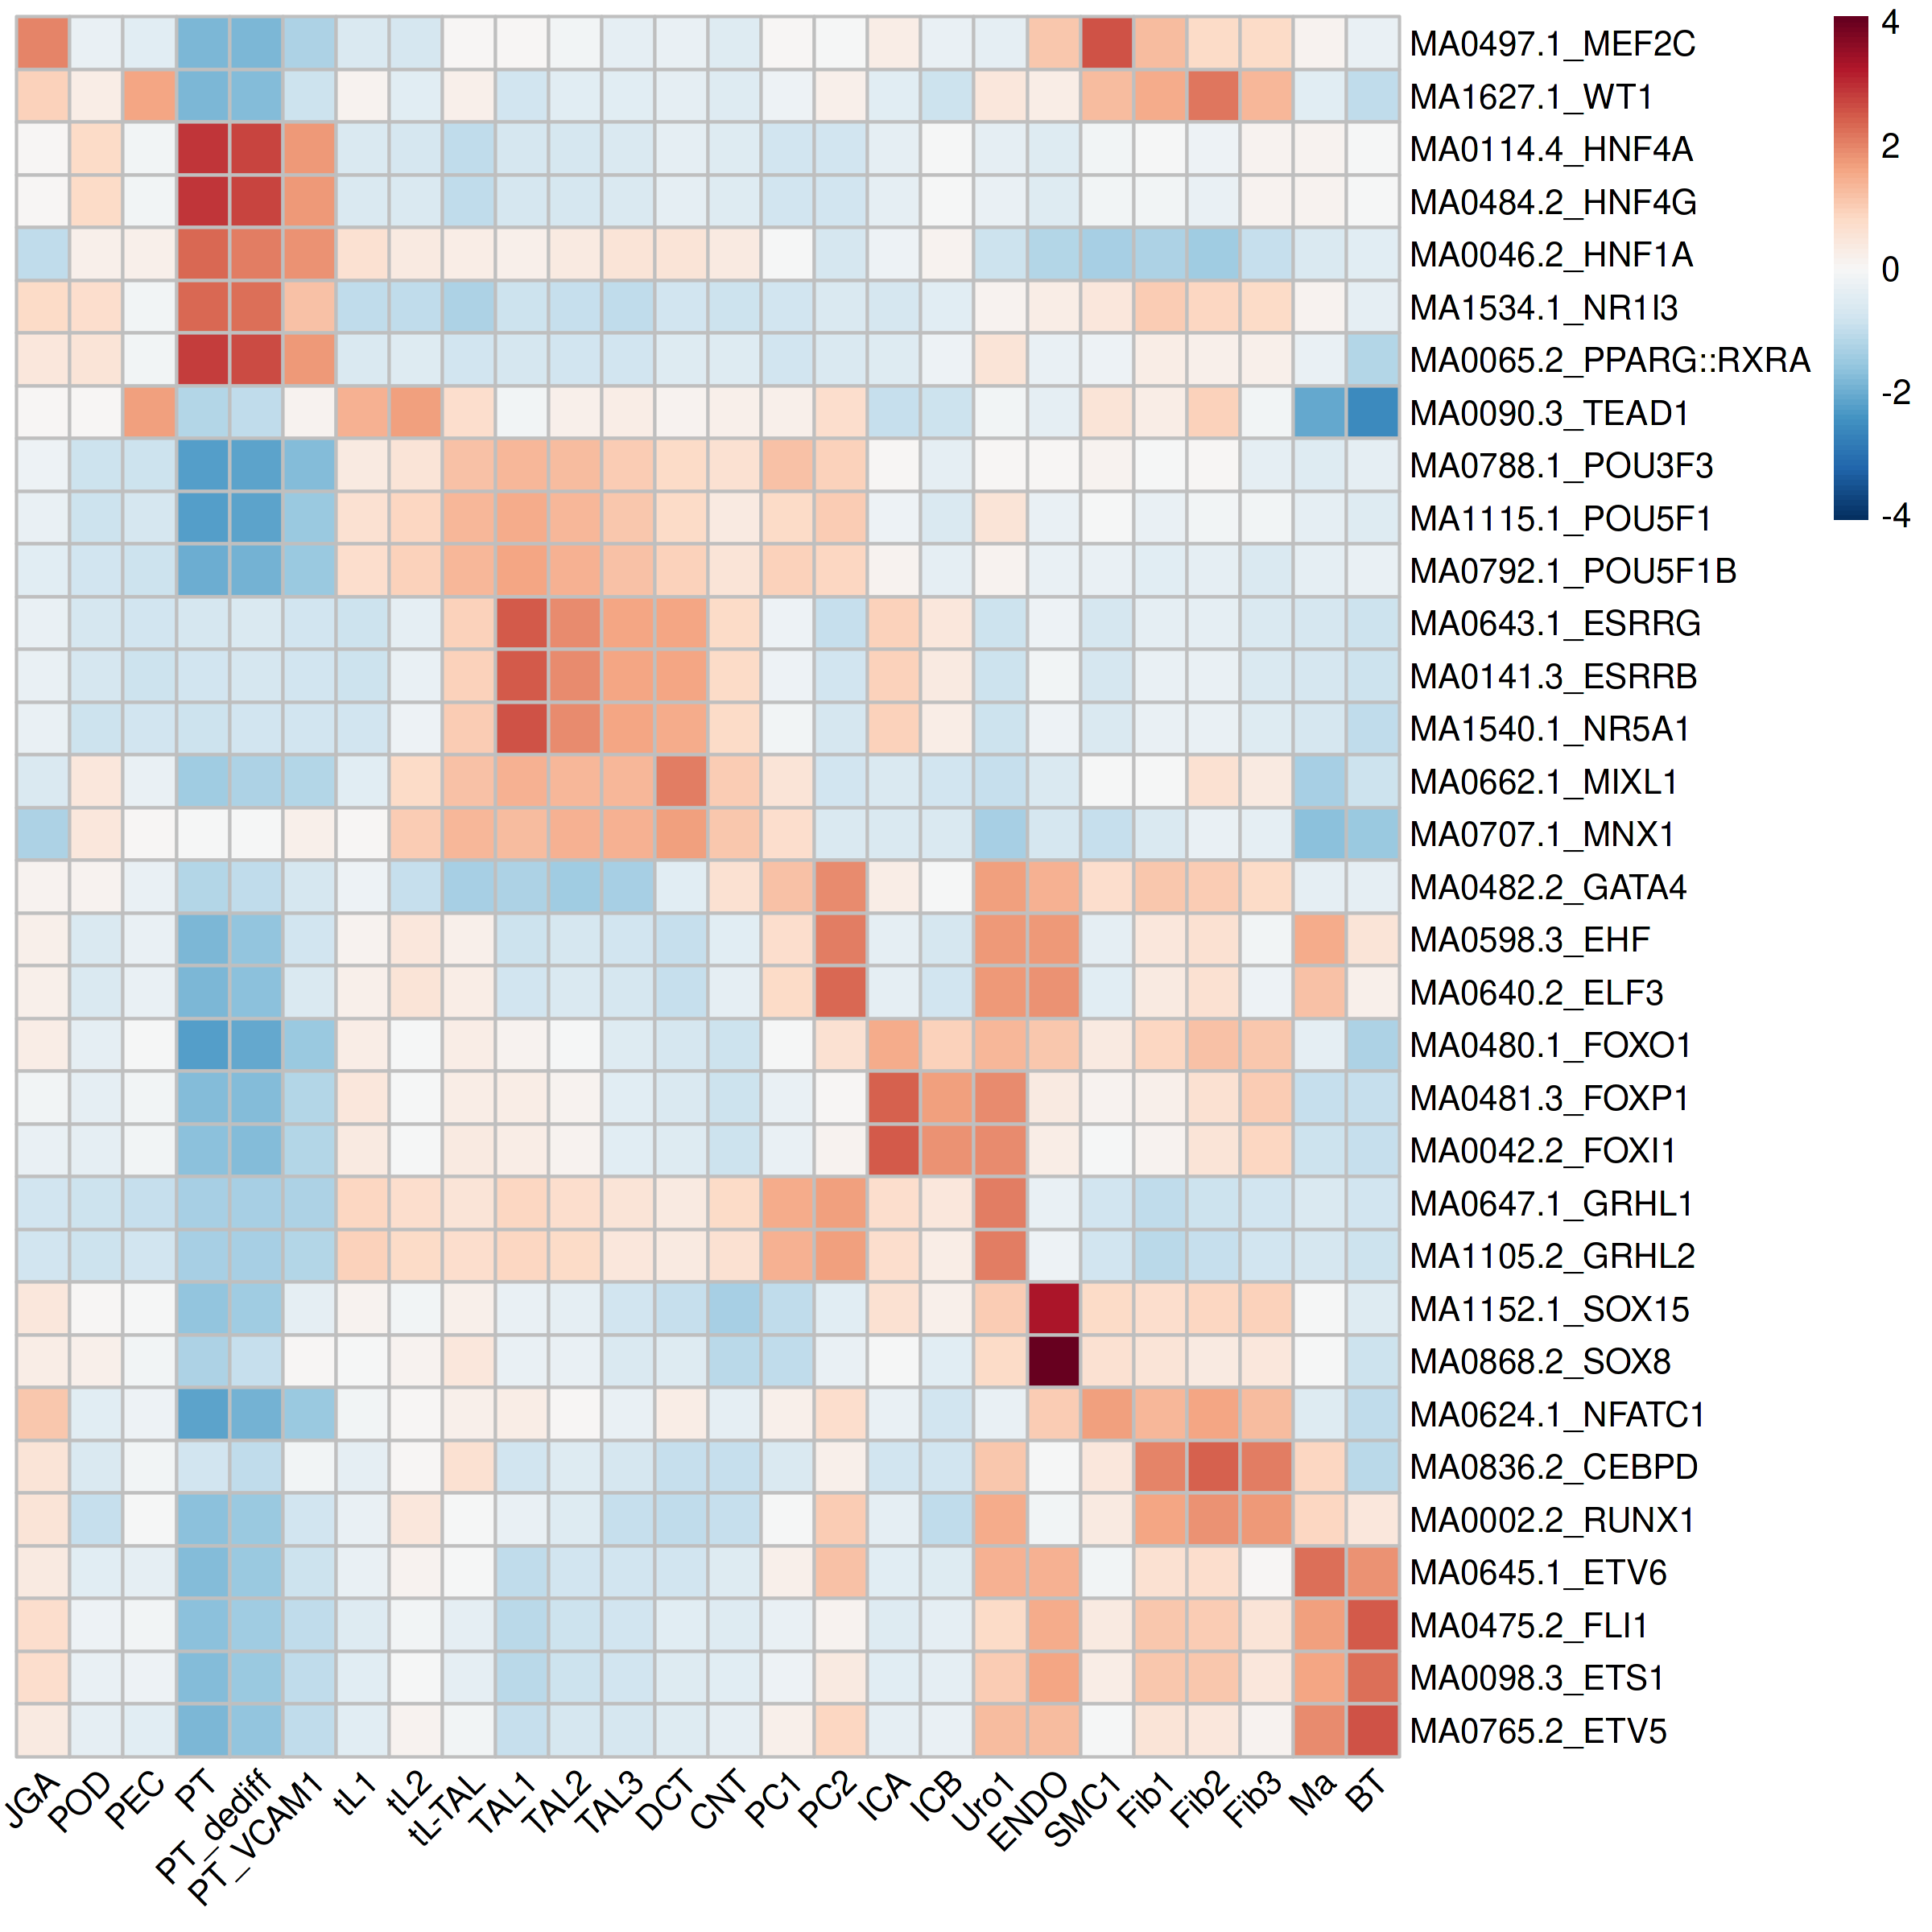

In [193]:
options(repr.plot.height = 8, repr.plot.width = 8, repr.plot.res = 300)

pheatmap::pheatmap(aver_chromvar,scale = "row",
                   cluster_cols=F,cluster_rows = F,
                   colorRampPalette(rev(brewer.pal(n = 11, name = "RdBu")))(100), 
                   border_color = "grey75",
                   show_rownames=T, angle_col=45)

In [194]:
novaseq_test

An object of class Seurat 
238268 features across 324701 samples within 3 assays 
Active assay: peaks (189184 features, 189184 variable features)
 2 other assays present: RNA, chromvar
 6 dimensional reductions calculated: pca, harmony_RNA, lsi, harmony_peaks, umap.peaks, WNN.UMAP

### extract corresponding RNA expression 

In [200]:
aver_RNA = get_aver(novaseq = novaseq_test,
        assays = "RNA",
        features = do.call(rbind, strsplit(list_use, "_"))[,2],
        slot="data")

Warning message:
“The following 1 features were not found in the RNA assay: PPARG::RXRA”


In [201]:
aver_RNA = aver_RNA[, !(colnames(aver_RNA) %in% c("Uro2", "SMC2", "SMC3"))]

In [202]:
colnames(aver_RNA) = gsub("\\.", "-", colnames(aver_RNA))

In [203]:
save(list = c("aver_RNA"), file = file.path(processed_dir, "aver_RNA.RData"), compress = T)

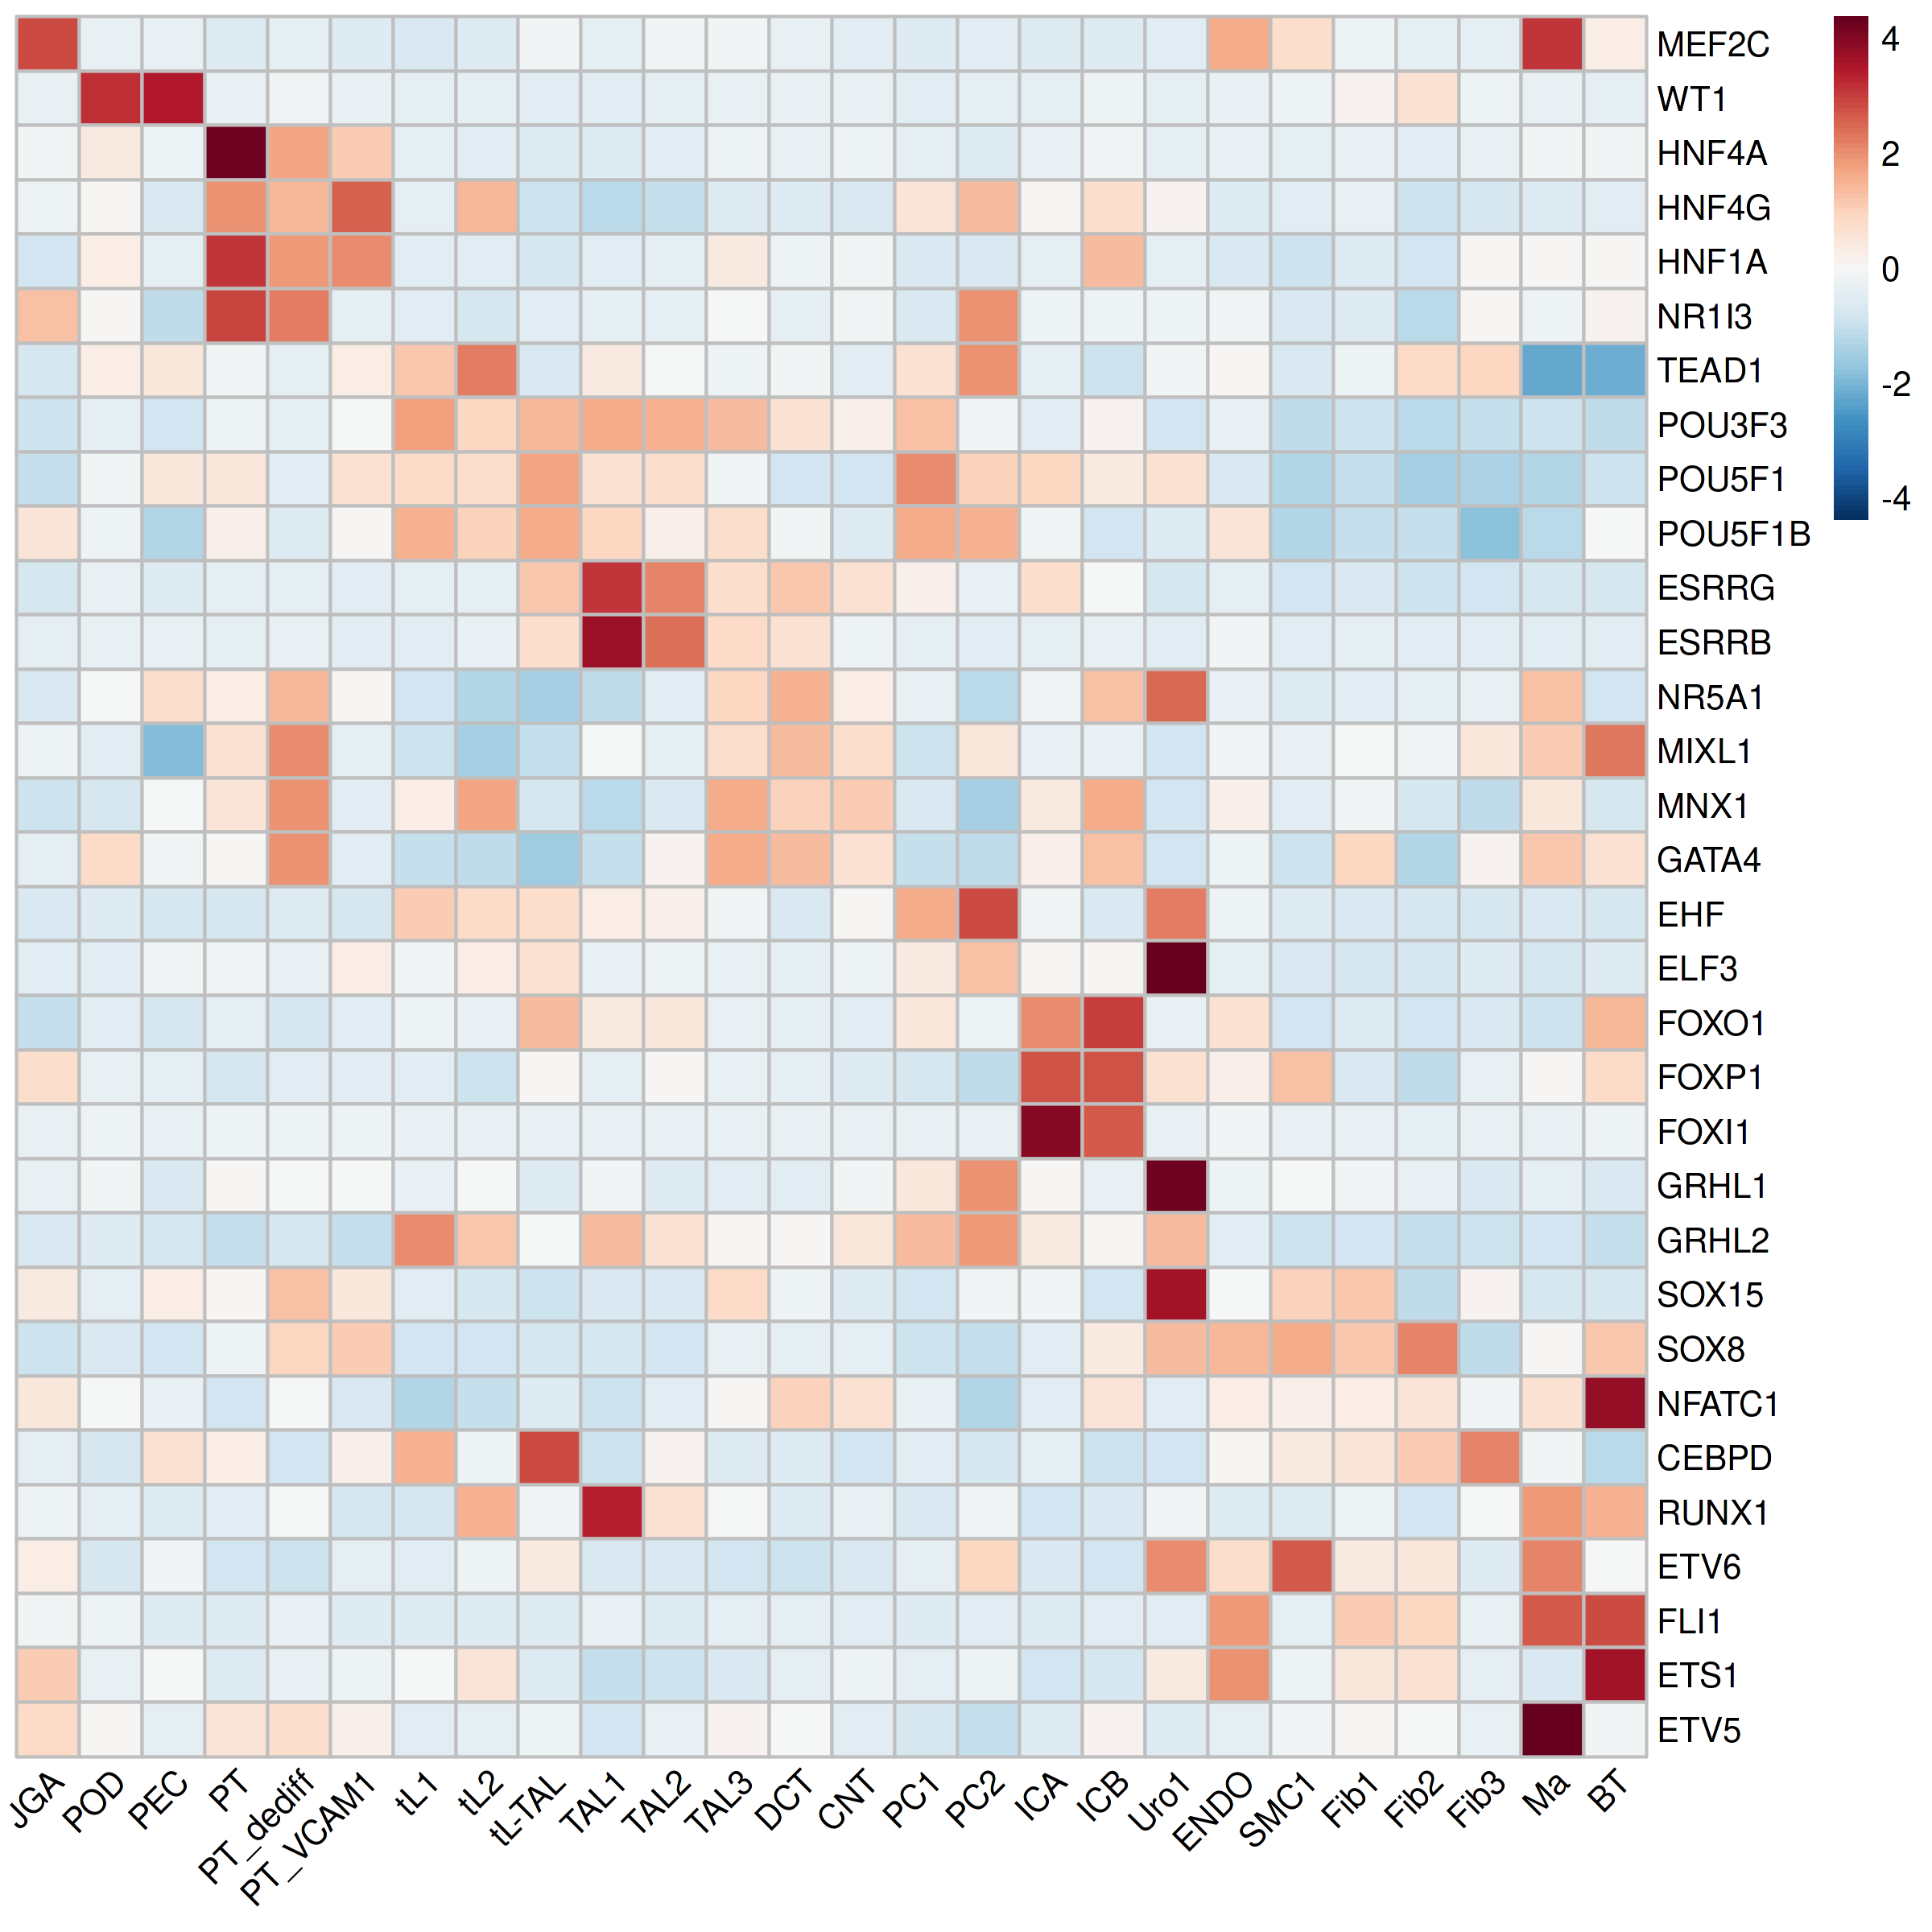

In [204]:
options(repr.plot.height = 8, repr.plot.width = 8, repr.plot.res = 300)

pheatmap::pheatmap(aver_RNA,scale = "row",
                   cluster_cols=F,cluster_rows = F,
                   colorRampPalette(rev(brewer.pal(n = 11, name = "RdBu")))(100), 
                   border_color = "grey75",
                   show_rownames=T, angle_col=45)

### correlation

In [206]:
dim(aver_RNA)
dim(aver_chromvar)

[1] 32 26

[1] 33 26

In [219]:
aver_chromvar_gene = unname(unlist(sapply(rownames(aver_chromvar), FUN = function(x){
    strsplit(x, "_")[[1]][2]
})))

In [222]:
df_RNA = data.frame("gene" = rownames(aver_RNA), "ind_RNA" = 1:dim(aver_RNA)[1])
df_chromvar = data.frame("gene" = aver_chromvar_gene, "ind_chromvar" = 1:dim(aver_chromvar)[1])
df_RNA_chromvar = dplyr::inner_join(df_RNA, df_chromvar, by = "gene")

In [228]:
for (i in 1:dim(aver_RNA)[2]){
    print(colnames(aver_RNA)[i])
    cor_res = cor.test(aver_RNA[df_RNA_chromvar$ind_RNA, i], aver_chromvar[df_RNA_chromvar$ind_chromvar, i])
    print(cor_res)
}


[1] "JGA"

	Pearson's product-moment correlation

data:  aver_RNA[df_RNA_chromvar$ind_RNA, i] and aver_chromvar[df_RNA_chromvar$ind_chromvar, i]
t = 1.28, df = 30, p-value = 0.2104
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1315682  0.5338948
sample estimates:
      cor 
0.2275659 

[1] "POD"

	Pearson's product-moment correlation

data:  aver_RNA[df_RNA_chromvar$ind_RNA, i] and aver_chromvar[df_RNA_chromvar$ind_chromvar, i]
t = -1.3037, df = 30, p-value = 0.2022
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5369006  0.1274251
sample estimates:
       cor 
-0.2315575 

[1] "PEC"

	Pearson's product-moment correlation

data:  aver_RNA[df_RNA_chromvar$ind_RNA, i] and aver_chromvar[df_RNA_chromvar$ind_chromvar, i]
t = 0.72703, df = 30, p-value = 0.4728
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2275523  0.4592069
sample estimates:
      c